# homework 07: Wiggins' lost labels
You're still sorting out the mess that poor Wiggins left behind when he quit the lab. In another set of experiments he was doing, it looks like he had isolated a mutant sand mouse in a screen, and characterized the mutation's effect on overall gene expression in RNA-seq experiments. He did two sets of three replicates on wild type control mice, and one set of three replicates on his mutant sand mice. But unfortunately, he mislabeled the files and lost track of which was which. He's still not responding to your emails, so you're going to have to do some more detective work.

**1. write a python function to run an external edgeR analysis**

Write a python function that takes the name of an input counts file as an argument (and any other arguments you need), and returns the results of an edgeR analysis: gene names, log fold changes, log CPM, P-values, and FDRs (and any other data you find you want to return).

You can use the poor hacker's style: have your python script write an R script to a file, run the R script externally with Rscript (see hints), and parse the resulting output file.

Use the same edgeR analysis steps that Wiggins' analyze_W.r script used.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Here we will write to a new file, and then run the r script using ! Rscript command to extract the values we want. Once we have done this we will save our data onto a df in pandas and do the next steps there: 

In [2]:
# takes file name as input, outputs df containing gene names, log fold changes, log CPM, P-values, and FDRs

def edger_reader(file):
    f = open('new.r', 'w')
    f.write('library(edgeR)\n')
    f.write('infile     <- "' + file + '"\n')
    f.write('group      <- factor(c(1,1,1,2,2,2))\n')
    f.write('outfile    <- "myresult.out"\n')
    f.write('x     <- read.table(infile, sep=\'\\t\', row.names=1)\n')
    f.write('y     <- DGEList(counts=x,group=group)\n')
    f.write('y     <- estimateDisp(y)\n')
    f.write('et    <- exactTest(y)\n')
    f.write('tab   <- topTags(et, nrow(x))\n')
    f.write('write.table(tab, file=outfile)\n')
    # closing our file
    f.close()

    # using the Rscript command to run the R file we just made
    ! Rscript new.r
    
    # Store in a pandas df, as it will make the parsing through the data easier
    df_data = pd.read_table('myresult.out', delim_whitespace=True)

    # Return the data frame we created with all the values
    return df_data


**2. reproduce Wiggins' data, assign the missing labels**

There are three possible combinations of Wiggins' data files: (1,2), (1,3), or (2,3). Using your Python function for running his edgeR analysis, run all three analyses.


Here we will join the three datafiles provided into the three specified combinations: (1,2), (1,3), and (2,3). Then these three joined data files will be run through the edge_R function we dfined above.


Here we start with data files 1 and 2:

Now we find the p-values < 0.05, which is our treshold, in the data frame. The result is our number of differentially expressed genes (at that treshold).

You can change the treshold of P-values to get different results.

In [3]:
# joining data files 1 and 2
! join -t $'\t' w07-data.1.txt w07-data.2.txt > df_12_pre

# running edge r analysis on newly merged file and storing it:
df_12 = edger_reader('df_12_pre')

p_12 = df_12[df_12['PValue']<0.05]

p_12.shape

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


(2246, 4)

Doing the same for data files 1 and 3:

also finding the differentially expressed genes at the given p-value treshold:

In [4]:
# joining data files 1 and 3
! join -t $'\t' w07-data.1.txt w07-data.3.txt > df_13_pre

# running edge r analysis on newly merged file and storing it:
df_13 = edger_reader('df_13_pre')

p_13 = df_13[df_13['PValue']<0.05]

p_13.shape

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


(988, 4)

And for data files 2 and 3:

also finding the differentially expressed genes at the given p-value treshold:

In [5]:
# joining data files 2 and 3
! join -t $'\t' w07-data.2.txt w07-data.3.txt > df_23_pre

# running edge r analysis on newly merged file and storing it:
df_23 = edger_reader('df_23_pre')

# p-values <0.05
p_23 = df_23[df_23['PValue']<0.05]

p_23.shape

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


(2312, 4)

**Which combination did he run to obtain his result of 2246 differentially expressed genes significant at P<0.05?**


this was obtained by running the combination of data file 1 and 2, as seen in our analysis above.

**Which of the three files corresponds to the mutant sand mouse samples? Why?**


It would be data set 2, since it is "differentially expressed" when compared to to the wildtype datasets 1 and 3.
A big hint for this is that, when we run the edge_R analysis for the merged data files 1 and 3, our result is 988 differentially expressed genes, which is a close enough approximation of the 1,000 differentially expressed genes we would expect to see in a pool of 20,000 genes (which is what our datafiles contain).

This is perfetly predicted by the p-value probabilities since 20,000 genes * 0.05 significant ones = 1,000 genes.
The two other combinations of files yield numbers of genes around twice as large as this calculation.


**3. Wiggins doesn't understand p-values**

**Do you agree with Wiggins' conclusion that 2246 genes are differentially expressed in that wt vs. mutant comparison? What did he fail to do?**
**Give a different conclusion of your own -- what is a more appropriate statistical cutoff, and how many genes are called differentially expressed at your threshold?**

Wiggins' conclusion seems to be wrong in that he does not understand that p-values are a measure for a single sample, not for three. 

Also, using 0.05 as a treshold actually turns out to be pretty lenient. A better way to do this might be to also consider the FDR treshold, along a stricter p-value treshold. We might expect to find a low number of differentially expressed genes being outputted by  data set 2 (files 1,3) when we do that.

Below, we will experiment with using a standard 0.05 FDR treshold as well as a very small one. We expect FDR to out-preform p-values in accuracy.

The FDR coems from the Benjamini procedure, which ranks genes based on p-values and then rejects based on a condition (https://en.wikipedia.org/wiki/False_discovery_rate)

In [6]:
# show the genes at which the FDR < 0.05
fdr_12_a = df_12[df_12['FDR']<0.05]
len(fdr_12_a)

74

In [7]:
# now show the genes at which the FDR < 0.001
fdr_12_b = df_12[df_12['FDR']<0.0001]
len(fdr_12_b)

50

We observe that, in fact, with the FDR < 0.05 as treshold, we only get 74 differentially expressed genes.
With FDR < 0.0001 we get even less (50). I also ran for 0.001 and it gave me 51, which means we are getting close to converging on a final number.

**4. Wiggins missed something else too**

Wiggins' analysis has a subtler problem. It's missing an important step in the edgeR analysis pipeline, and it just happens (!) that this example exercises exactly the problem that that edgeR step is designed to deal with. Find it and fix it -- you'll need to add one step in the R analysis script -- and rerun the analysis. 

Now how many genes do you think are differentially expressed? What was the problem? (see hints)

The subtle problem is that Wiggins did not normalize using TMM in his script to do edge r. This is problematic because it solves the issue of the normalization of indirect effects.

RNA seq experiments will consider the relative abundances within a sample, which depend on other genes, instead of the absolute abundances. Having some over-expressed genes will thus affect the results since the other genes will be made to look as if they were under-expressed. This could incorrectly pass as a stat significant change, even though it's not.

Instead we want our analysis to measure the direct effects that are stat significant and not the indirect effects that are "noise".
Using TMM helps us to normalize by considering the abrnomally expressed genes and thus we get a lower number of "differentially expressed" genes as a result.

From reading the edge R manual, I learned that it works with the assumption that most genes are not diff expressed across our various samples, and then minimizes the number of genes with expression differences. Then it finds an adequate library size for this.

We now will see how out new reader function works by adding the TMM step:

Re-running with this modification in mind:

In [8]:
def edger_reader(file):
    f = open('new.r', 'w')
    f.write('library(edgeR)\n')
    f.write('infile     <- "' + file + '"\n')
    f.write('group      <- factor(c(1,1,1,2,2,2))\n')
    f.write('outfile    <- "myresult.out"\n')
    f.write('x     <- read.table(infile, sep=\'\\t\', row.names=1)\n')
    f.write('y     <- DGEList(counts=x,group=group)\n')
    f.write('y     <- calcNormFactors(y)\n')    # this is our newly added line to do TMM
    f.write('y     <- estimateDisp(y)\n')
    f.write('et    <- exactTest(y)\n')
    f.write('tab   <- topTags(et, nrow(x))\n')
    f.write('write.table(tab, file=outfile)\n')
    # closing our file
    f.close()

    # using the Rscript command to run the R file we just made
    ! Rscript new.r
    
    # Store in a pandas df, as it will make the parsing through the data easier
    df_data = pd.read_table('myresult.out', delim_whitespace=True)

    # Return the data frame we created with all the values
    return df_data


Repeat the steps from the previous question to run this new version of edger_reader using our additional TMM step:

In [9]:
tmm_12 = edger_reader('df_12_pre')

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


Analyze this df using the cutoffs for FDR at < 0.05, 0.01 and 0.001

In [10]:
# show the genes at which the FDR < 0.05
fdr_12_a = tmm_12[tmm_12['FDR']<0.05]
len(fdr_12_a)

53

In [11]:
# show the genes at which the FDR < 0.05
fdr_12_b = tmm_12[tmm_12['FDR']<0.01]
len(fdr_12_b)

51

In [12]:
# show the genes at which the FDR < 0.05
fdr_12_c = tmm_12[tmm_12['FDR']<0.001]
len(fdr_12_b)

51

As predicted, we see a decrease in the number of differentially expressed genes when using this FDR cutoff here with the TMM addition.

Before including TMM we had an ouput of 74 diff epressed genes and now we have an output of 53.

This translate to a more accurate and efficient way of analyzing stat significance.

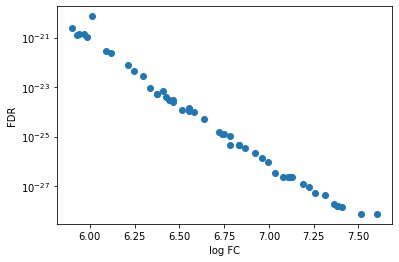

In [16]:
# Scatter plot comparing log fold changes to FDR
plt.scatter(fdr_12_c.logFC, fdr_12_c.FDR)
plt.xlabel('log FC')
plt.ylabel('FDR')
plt.yscale('log')

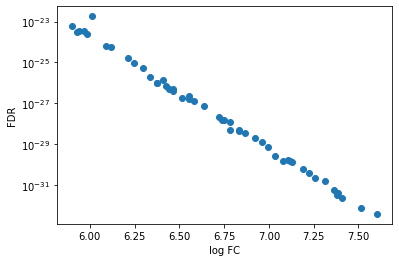

In [19]:
# Scatter plot comparing log fold changes to p-values
plt.scatter(fdr_12_c.logFC, fdr_12_c.PValue)
plt.xlabel('log FC')
plt.ylabel('FDR')
plt.yscale('log')

From the two scatterplots above we conclude the following:

In the second plot, there is a correlation between the highest p-values and a low log fold score. The first plot is similar, where high FDR seems to correlate with low logFC (pretty linearly).

There are some genes in the data that are over-expressed, and as discussed above, throw off the relative abundance data.
